In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append('./src/jubilee_pipette_bodemo/')
sys.path.append('../bayesopt')

from science_jubilee import Machine as Jub
from science_jubilee.labware.Labware import Labware, Well
from science_jubilee.tools import Pipette, WebCamera, Tool

import color_match
from color_match import BO_campaign
import jubilee_protocols

from bayesopt import acquisitions
from bayesopt import bayesian_optimizer

import ipywidgets as widgets
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from math import sqrt, acos, asin, cos, sin
import copy

import json

## Machine setup and connection

In [4]:
jubilee = Jub.Machine(address='192.168.1.2')

In [5]:
jubilee.home_all()

In [5]:
jubilee.move_to(z = 115)

In [10]:
deck = jubilee.load_deck('lab_automation_deck.json')
tiprack = jubilee.load_labware('opentrons_96_tiprack_300ul.json', 0)
samples = jubilee.load_labware('corning_96_wellplate_360ul_flat.json', 2)
stocks = jubilee.load_labware('20mlscintillation_12_wellplate_18000ul.json', 3)
trash = jubilee.load_labware('agilent_1_reservoir_290ml.json', 1)

In [7]:
#configure pipette
P300 = Pipette.Pipette.from_config(1, 'Pipette', 'P300_config.json')
jubilee.load_tool(P300)
P300.add_tiprack(tiprack)

In [8]:
#configure camera
Camera = WebCamera.Camera.from_config(0, 'Camera', 'WebCamera_config.json')
jubilee.load_tool(Camera)

In [9]:
# apply offset to samples for mixer module 
#samples.offset = (0, 0, 40.0)

### Manual offset input

In [11]:
# tiprack
UL = [30.0,79.0]
UR = [129.0, 79.4]
BR = [129.5, 16.9]

tiprack.manual_offset((UL, UR, BR), save = True) #, save=True, force=True)

Labware already has a manual offset found for this slot. If you want to overwrite it, set save=True
New manual offset applied to opentrons_96_tiprack_300ul
stored manual offset found.  To overwrite it on the `config.json` file, set force=True


In [12]:
# samples
UL = [32.3,176.4]
UR = [123.4, 176.9]
BR = [123.7, 112.6]

samples.manual_offset((UL, UR, BR), save=True)

Labware already has a manual offset found for this slot. If you want to overwrite it, set save=True
New manual offset applied to corning_96_wellplate_360ul_flat
stored manual offset found.  To overwrite it on the `config.json` file, set force=True


In [13]:
# stocks
UL = [175.5, 171.5]
UR = [259.3, 172.1]
BR = [259.9, 117.0]

stocks.manual_offset((UL, UR, BR), save=True)

Labware already has a manual offset found for this slot. If you want to overwrite it, set save=True
New manual offset applied to 20mlscintillation_12_wellplate_18000ul
stored manual offset found.  To overwrite it on the `config.json` file, set force=True


## Color picking

In [14]:
a = widgets.ColorPicker(
    concise=False,
    description='Pick a color',
    value='blue',
    disabled=False
)

In [15]:
a

ColorPicker(value='blue', description='Pick a color')

In [16]:
hexcode = a.value


In [17]:
target_rgb = tuple(int(hexcode.lstrip('#')[i:i+2], 16) for i in (0,2,4))
target_color = color_match.normalize_color(target_rgb)

In [18]:
target_color

[0.5019607843137255, 0.0, 0.5019607843137255]

## Set up things for demo

In [19]:
red_stock = stocks[0]
yellow_stock = stocks[2]
blue_stock = stocks[1]
trash_well = trash[0]

In [20]:
sample_space = color_match.get_constrained_points(101)

## Get initial data

In [18]:
n_init_points = 6
sampled_indices = np.random.randint(0, len(sample_space), size = n_init_points)
sampled_points = sample_space[sampled_indices]

In [19]:
rgb_vals = []
for i in range(len(sampled_points)):
    point = sampled_points[i,:]
    well = samples[i]
    print('creating sample')
    print(point)
    print(well)
    
    RGB = jubilee_protocols.sample_point(jubilee, P300, Camera, point, 250, well, red_stock, yellow_stock, blue_stock, trash_well)
    rgb_vals.append(RGB)

creating sample
[0.31 0.66 0.03]
Well(name='A1', depth=10.67, totalLiquidVolume=360, shape='circular', diameter=6.86, xDimension=None, yDimension=None, x=28.68, y=175.04, z=3.55, offset=[14.3, 100.8], slot=2)
Start of sample sequence position:  {'X': '283.500', 'Y': '305.000', 'Z': '115.000', 'U': '0.000', 'V': '0.500', 'E': '0.000'}
Calculated volumes:  [77.5, 165.0, 7.5]
creating sample
[0.33 0.55 0.12]
Well(name='A2', depth=10.67, totalLiquidVolume=360, shape='circular', diameter=6.86, xDimension=None, yDimension=None, x=37.68, y=175.04, z=3.55, offset=[14.3, 100.8], slot=2)
Start of sample sequence position:  {'X': '283.500', 'Y': '305.000', 'Z': '186.490', 'U': '0.000', 'V': '310.000', 'E': '0.000'}
Calculated volumes:  [82.5, 137.5, 30.0]
creating sample
[0.61 0.05 0.34]
Well(name='A3', depth=10.67, totalLiquidVolume=360, shape='circular', diameter=6.86, xDimension=None, yDimension=None, x=46.68000000000001, y=175.04, z=3.55, offset=[14.3, 100.8], slot=2)
Start of sample sequence

In [20]:
init_data = []
for i in range(len(sampled_points)):
    data = {}
    data['sample_id'] = str(i)
    data['RYB_point'] = list(sampled_points[i])
    data['RGB_measured'] = rgb_vals[i]

    init_data.append(data)

In [21]:
init_data

[{'sample_id': '0',
  'RYB_point': [0.31, 0.66, 0.03],
  'RGB_measured': [83.23502304147465, 118.24104927330734, 192.92520382842963]},
 {'sample_id': '1',
  'RYB_point': [0.33, 0.55, 0.12],
  'RGB_measured': [90.26444523218717, 110.71924849344204, 160.95214462956397]},
 {'sample_id': '2',
  'RYB_point': [0.61, 0.05, 0.34],
  'RGB_measured': [121.29457639135059, 89.44381425026586, 120.57107408720312]},
 {'sample_id': '3',
  'RYB_point': [0.05, 0.74, 0.21],
  'RGB_measured': [93.89471818504076, 147.87344913151364, 146.13293158454448]},
 {'sample_id': '4',
  'RYB_point': [0.11, 0.56, 0.33],
  'RGB_measured': [98.11059907834101, 124.2782701169798, 116.6650124069479]},
 {'sample_id': '5',
  'RYB_point': [0.32, 0.64, 0.04],
  'RGB_measured': [82.77738390641616, 112.85218007798653, 187.83374689826303]}]

In [24]:
with open('initial_data_random_6.jsonl', 'wt') as f:
    for entry in init_data:
        f.write(json.dumps(entry) + '\n')

## Run BO campaign to make target color 

### Load initial data and calculate loss value for target color 

In [21]:
init_data = []

with open('initial_data_random_6.jsonl', 'rt') as f:
    for line in f:
        init_data.append(json.loads(line))

In [22]:
init_X = np.zeros((len(init_data),3))
init_y = np.zeros(len(init_data))

for i, entry in enumerate(init_data):
    init_X[i,:] = entry['RYB_point']
    init_y[i] = color_match.color_loss_calculation(target_color, color_match.normalize_color(entry['RGB_measured']))

### Select acquisition function

In [23]:
acquisition_function = acquisitions.optimize_PI
acq_kwargs = {'xi':0.3}

In [24]:
initial_data = (init_X, init_y)
number_of_iterations = 10

In [28]:
P300.drop_tip(trash[0])

Starting iteration 0
Dispensing into well Well(name='A1', depth=10.67, totalLiquidVolume=360, shape='circular', diameter=6.86, xDimension=None, yDimension=None, x=27.790954788973195, y=175.1833520398478, z=3.55, offset=[14.3, 100.8], slot=2)
RYB values tested: [0. 0. 1.]
Calculated volumes:  [0.0, 0.0, 250.0]
RGB values observed: {RGB}
Starting iteration 1
Dispensing into well Well(name='A2', depth=10.67, totalLiquidVolume=360, shape='circular', diameter=6.86, xDimension=None, yDimension=None, x=36.790838797196834, y=175.22904491150624, z=3.55, offset=[14.3, 100.8], slot=2)
RYB values tested: [1. 0. 0.]
Calculated volumes:  [250.0, 0.0, 0.0]
RGB values observed: {RGB}
Starting iteration 2
Dispensing into well Well(name='A3', depth=10.67, totalLiquidVolume=360, shape='circular', diameter=6.86, xDimension=None, yDimension=None, x=45.79072280542048, y=175.27473778316468, z=3.55, offset=[14.3, 100.8], slot=2)
RYB values tested: [0.7 0.3 0. ]
Calculated volumes:  [175.00000000000003, 75.0, 

ValueError: not enough values to unpack (expected 5, got 4)

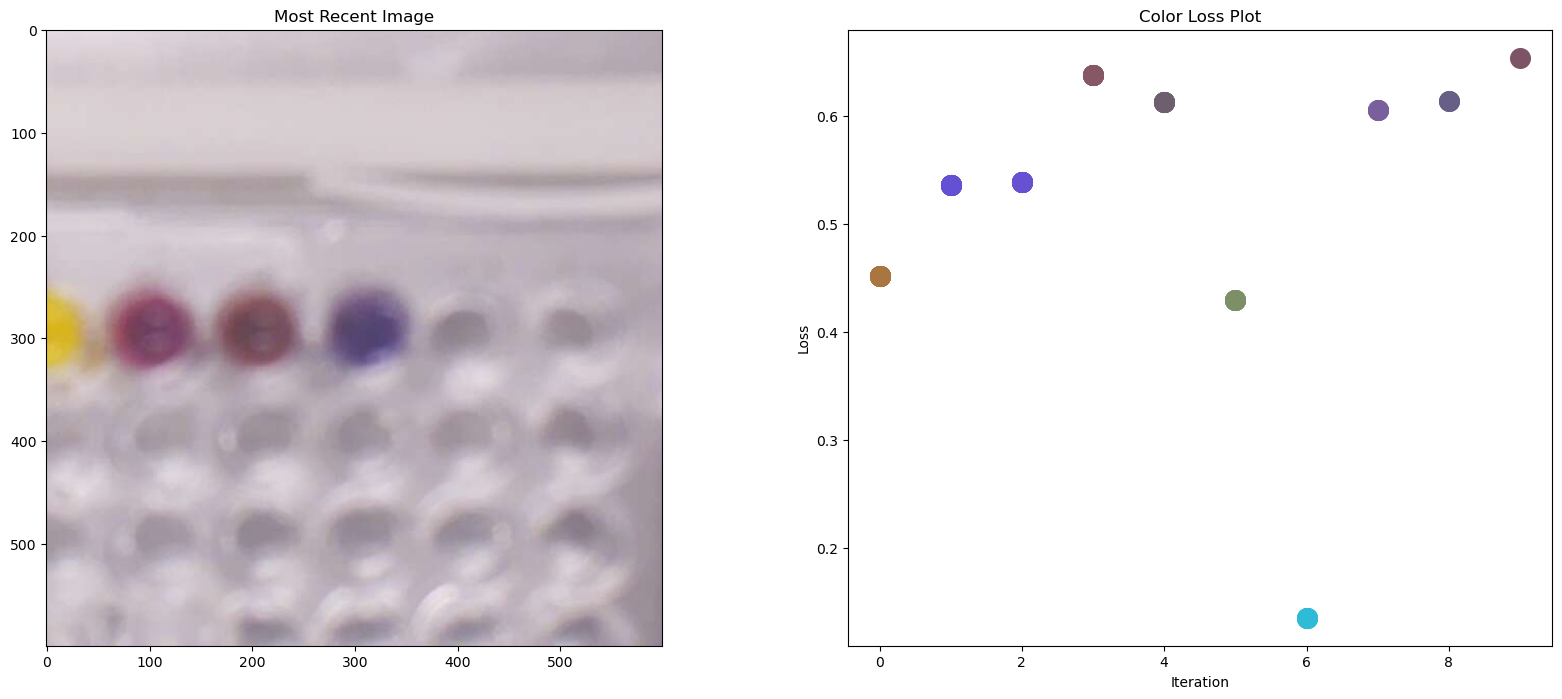

In [29]:
ryb_sampled, rgb_measured, images, scores, bo_obj = BO_campaign(initial_data, acquisition_function, acq_kwargs, number_of_iterations, target_color, jubilee, P300, Camera, 250, stocks['A1'], stocks['A3'], stocks['A2'], samples, trash[0], start_well = 0)

In [38]:
len(samples.wells)

96